In [1]:
!pip install -q seaborn
!pip install -q git+https://github.com/tensorflow/docs

In [2]:
from __future__ import absolute_import, division, print_function, unicode_literals

import pathlib

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

In [3]:
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers

print(tf.__version__)

2.0.0


In [4]:
import tensorflow_docs as tfdocs
import tensorflow_docs.plots
import tensorflow_docs.modeling

In [5]:
# Download the Auto MPG dataset
dataset_path = keras.utils.get_file("auto-mpg.data", "http://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data")
dataset_path

'/home/jovyan/.keras/datasets/auto-mpg.data'

In [6]:
# Import dataset via pandas
column_names = ['MPG','Cylinders','Displacement','Horsepower','Weight',
                'Acceleration', 'Model Year', 'Origin']
raw_dataset = pd.read_csv(dataset_path, names=column_names,
                      na_values = "?", comment='\t',
                      sep=" ", skipinitialspace=True)

dataset = raw_dataset.copy()
dataset.tail()


,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Origin
393,27.0,4,140.0,86.0,2790.0,15.6,82,1
394,44.0,4,97.0,52.0,2130.0,24.6,82,2
395,32.0,4,135.0,84.0,2295.0,11.6,82,1
396,28.0,4,120.0,79.0,2625.0,18.6,82,1
397,31.0,4,119.0,82.0,2720.0,19.4,82,1


In [7]:
# Data NA inspection
dataset.isna().sum()

MPG             0
Cylinders       0
Displacement    0
Horsepower      6
Weight          0
Acceleration    0
Model Year      0
Origin          0
dtype: int64

In [8]:
# Clean data
# Drop NA rows, keep it simple
dataset = dataset.dropna()
# Origin is categorical not numeric, so convert to a "one-hot"
dataset['Origin'] = dataset['Origin'].map(lambda x: {1: 'USA', 2: 'Europe', 3: 'Japan'}.get(x))

In [9]:
dataset = pd.get_dummies(dataset, prefix='', prefix_sep='')
dataset.tail()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Europe,Japan,USA
393,27.0,4,140.0,86.0,2790.0,15.6,82,0,0,1
394,44.0,4,97.0,52.0,2130.0,24.6,82,1,0,0
395,32.0,4,135.0,84.0,2295.0,11.6,82,0,0,1
396,28.0,4,120.0,79.0,2625.0,18.6,82,0,0,1
397,31.0,4,119.0,82.0,2720.0,19.4,82,0,0,1


In [10]:
# Now the work can begin

# Split data into train vs. test
# Test set will be used for final evaluation of model

train_dataset = dataset.sample(frac=0.8,random_state=0)
test_dataset = dataset.drop(train_dataset.index)

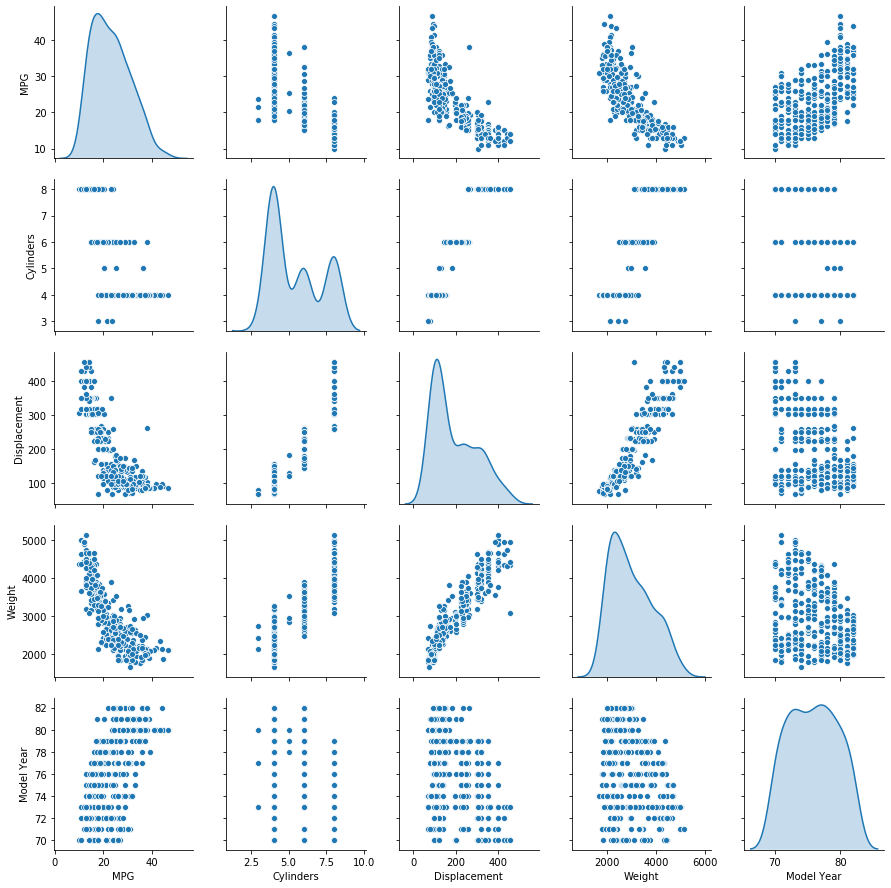

In [11]:
# Inspect the data
sns.pairplot(train_dataset[["MPG", "Cylinders", "Displacement", "Weight", "Model Year"]], diag_kind="kde")

In [12]:
# Data Statistics
train_stats = train_dataset.describe()
train_stats.pop("MPG")
train_stats = train_stats.transpose()
train_stats

,count,mean,std,min,25%,50%,75%,max
Cylinders,314.0,5.477707,1.699788,3.0,4.00,4.0,8.00,8.0
Displacement,314.0,195.318471,104.331589,68.0,105.50,151.0,265.75,455.0
Horsepower,314.0,104.869427,38.096214,46.0,76.25,94.5,128.00,225.0
Weight,314.0,2990.251592,843.898596,1649.0,2256.50,2822.5,3608.00,5140.0
Acceleration,314.0,15.559236,2.789230,8.0,13.80,15.5,17.20,24.8
Model Year,314.0,75.898089,3.675642,70.0,73.00,76.0,79.00,82.0
Europe,314.0,0.178344,0.383413,0.0,0.00,0.0,0.00,1.0
Japan,314.0,0.197452,0.398712,0.0,0.00,0.0,0.00,1.0
USA,314.0,0.624204,0.485101,0.0,0.00,1.0,1.00,1.0


In [13]:
# Split features from labels
# We want to use the MPG as the target value / "label" to train the model to predict
train_labels = train_dataset.pop('MPG')
test_labels = test_dataset.pop('MPG')

In [14]:
# Normalize the data

# Good practice because different scales and ranges could make training more difficult
# therefore feature normalization will make the resulting model less dependent upon the
# choice of units used in the input.

def norm(x):
  return (x - train_stats['mean']) / train_stats['std']
normed_train_data = norm(train_dataset)
normed_test_data = norm(test_dataset)

# Caution: The statistics used to normalize the inputs here (mean and standard deviation) 
# need to be applied to any other data that is fed to the model, along with the one-hot 
# encoding that we did earlier. That includes the test set as well as live data when the
# model is used in production.

In [30]:
# Build ML model

# Two densely connected layers
# Followed by a output layer that returns a single, continuous value

def build_model():
  model = keras.Sequential([
    layers.Dense(64, activation='relu', input_shape=[len(train_dataset.keys())]),
    layers.Dense(64, activation='relu'),
    layers.Dense(1)
  ])

  optimizer = tf.keras.optimizers.RMSprop(0.001)

  model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
  return model

# V2 model - using L2 weight regularization
def build_model_V2():
  model = keras.Sequential([
    layers.Dense(128, kernel_regularizer=tf.keras.regularizers.l2(0.001), bias_regularizer=tf.keras.regularizers.l2(0.001), input_shape=[len(train_dataset.keys())]),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.Dropout(0.5),
    layers.Dense(128, kernel_regularizer=tf.keras.regularizers.l2(0.001), bias_regularizer=tf.keras.regularizers.l2(0.001)),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.Dropout(0.5),
    layers.Dense(1)
  ])

  optimizer = tf.keras.optimizers.RMSprop(0.001)

  model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
  return model

model = None
model = build_model_V2()

In [31]:
# Inspect the model
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_6 (Dense)              (None, 128)               1280      
_________________________________________________________________
batch_normalization_2 (Batch (None, 128)               512       
_________________________________________________________________
activation_2 (Activation)    (None, 128)               0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 128)               16512     
_________________________________________________________________
batch_normalization_3 (Batch (None, 128)               512       
_________________________________________________________________
activation_3 (Activation)    (None, 128)              

In [32]:
# Test out the model
example_batch = normed_train_data[:10]
example_batch

,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Europe,Japan,USA
146,-0.869348,-1.009459,-0.784052,-1.025303,-0.379759,-0.516397,-0.465148,-0.495225,0.774676
282,-0.869348,-0.530218,-0.442811,-0.118796,0.624102,0.843910,-0.465148,-0.495225,0.774676
69,1.483887,1.482595,1.447140,1.736877,-0.738281,-1.060519,-0.465148,-0.495225,0.774676
378,-0.869348,-0.865687,-1.099044,-1.025303,-0.308055,1.660094,-0.465148,-0.495225,0.774676
331,-0.869348,-0.942365,-0.994047,-1.001603,0.875068,1.115971,-0.465148,2.012852,-1.286751
257,0.307270,0.351586,-0.390312,0.260397,0.588250,0.571849,-0.465148,-0.495225,0.774676
310,-0.869348,-1.019044,-1.177792,-1.211344,1.161885,1.115971,-0.465148,2.012852,-1.286751
328,-0.869348,-0.472709,-0.994047,0.307796,2.237451,1.115971,2.143005,-0.495225,-1.286751
125,0.307270,0.025702,-0.259066,0.132419,0.337285,-0.516397,-0.465148,-0.495225,0.774676
108,-0.869348,-0.942365,-0.442811,-0.842816,1.233589,-0.788458,-0.465148,2.012852,-1.286751


In [33]:
example_result = model.predict(example_batch)
example_result

array([[0.09134252],
       [0.07359558],
       [0.23248518],
       [0.10494357],
       [0.29932553],
       [0.01961822],
       [0.35258207],
       [0.33527452],
       [0.04569989],
       [0.18746127]], dtype=float32)

In [34]:
# Train the model
# Record training and validation accuracy in the HISTORY object

EPOCHS = 1000

history = model.fit(
  normed_train_data, train_labels,
  epochs=EPOCHS, validation_split = 0.2, verbose=0,
  callbacks=[tfdocs.modeling.EpochDots()])


Epoch: 0, loss:549.3771,  mae:22.2079,  mse:549.2312,  val_loss:597.7653,  val_mae:23.3183,  val_mse:597.6192,  
....................................................................................................
Epoch: 100, loss:24.5240,  mae:3.6117,  mse:24.3552,  val_loss:13.0033,  val_mae:2.9245,  val_mse:12.8344,  
....................................................................................................
Epoch: 200, loss:14.9675,  mae:2.8827,  mse:14.7788,  val_loss:9.7686,  val_mae:2.4801,  val_mse:9.5798,  
....................................................................................................
Epoch: 300, loss:21.5569,  mae:3.4452,  mse:21.3485,  val_loss:8.9621,  val_mae:2.4212,  val_mse:8.7537,  
....................................................................................................
Epoch: 400, loss:17.9135,  mae:3.2199,  mse:17.6867,  val_loss:9.4668,  val_mae:2.4290,  val_mse:9.2399,  
....................................................

In [35]:
# Visualize training progress via history object
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

,loss,mae,mse,val_loss,val_mae,val_mse,epoch
995,14.806668,2.896732,14.502178,8.055534,2.175320,7.751291,995
996,16.915976,2.946787,16.611738,7.982650,2.122472,7.678515,996
997,13.069641,2.651258,12.765460,7.665212,2.107967,7.361023,997
998,13.591752,2.826682,13.287603,7.088100,2.004295,6.784064,998
999,12.417072,2.682485,12.113158,6.636252,1.934860,6.332290,999


Text(0, 0.5, 'MAE [MPG]')

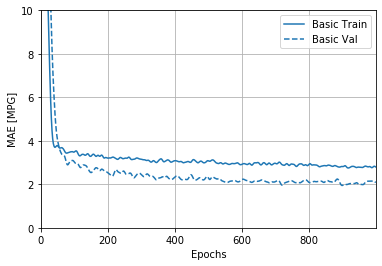

In [36]:
plotter = tfdocs.plots.HistoryPlotter(smoothing_std=2)
plotter.plot({'Basic': history}, metric = "mae")
plt.ylim([0, 10])
plt.ylabel('MAE [MPG]')
# Text(0, 0.5, 'MAE [MPG]')

Text(0, 0.5, 'MSE [MPG^2]')

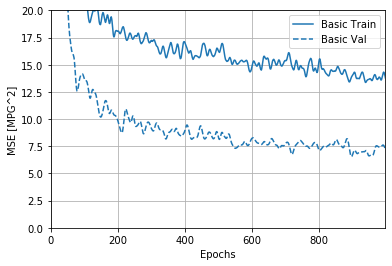

In [37]:
plotter.plot({'Basic': history}, metric = "mse")
plt.ylim([0, 20])
plt.ylabel('MSE [MPG^2]')


Epoch: 0, loss:563.2287,  mae:22.4520,  mse:563.2288,  val_loss:553.8715,  val_mae:22.1920,  val_mse:553.8715,  
..................................................

Text(0, 0.5, 'MAE [MPG]')

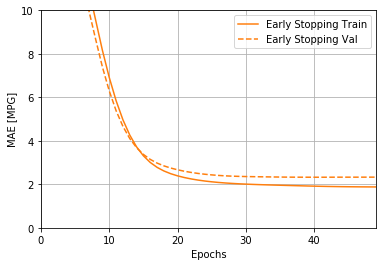

In [38]:
# This graph shows little improvement, or even degradation in the validation error after about 100 epochs. 
# Let's update the model.fit call to automatically stop training when the validation score doesn't improve. 
# We'll use an EarlyStopping callback that tests a training condition for every epoch. If a set amount of 
# epochs elapses without showing improvement, then automatically stop the training.

model = build_model()

# The patience parameter is the amount of epochs to check for improvement
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

early_history = model.fit(normed_train_data, train_labels, 
                    epochs=EPOCHS, validation_split = 0.2, verbose=0, 
                    callbacks=[early_stop, tfdocs.modeling.EpochDots()])

plotter.plot({'Early Stopping': early_history}, metric = "mae")
plt.ylim([0, 10])
plt.ylabel('MAE [MPG]')

In [39]:
# The graph shows that on the validation set, the average error is usually around +/- 2 MPG. 
# Is this good? 
# We'll leave that decision up to you.

# Let's see how well the model generalizes by using the test set, which we did not use when training the model. 
# This tells us how well we can expect the model to predict when we use it in the real world.

loss, mae, mse = model.evaluate(normed_test_data, test_labels, verbose=2)

print("Testing set Mean Abs Error: {:5.2f} MPG".format(mae))

78/78 - 0s - loss: 5.9451 - mae: 1.8630 - mse: 5.9451
Testing set Mean Abs Error:  1.86 MPG


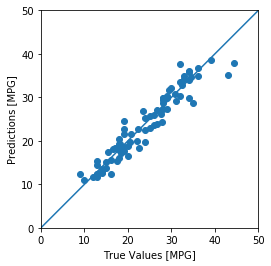

In [40]:
# We have a model
# Let's make some actual predictions

test_predictions = model.predict(normed_test_data).flatten()

a = plt.axes(aspect='equal')
plt.scatter(test_labels, test_predictions)
plt.xlabel('True Values [MPG]')
plt.ylabel('Predictions [MPG]')
lims = [0, 50]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)

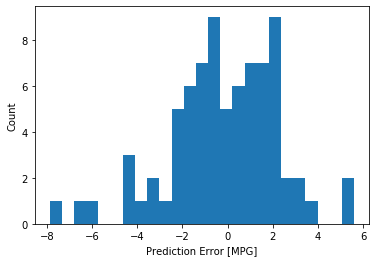

In [41]:
# Error distribution visualization
error = test_predictions - test_labels
plt.hist(error, bins = 25)
plt.xlabel("Prediction Error [MPG]")
_ = plt.ylabel("Count")

# Conclusion

This notebook introduced a few techniques to handle a regression problem.

- Mean Squared Error (MSE) is a common loss function used for regression problems (different loss functions are used for classification problems).
- Similarly, evaluation metrics used for regression differ from classification. A common regression metric is Mean Absolute Error (MAE).
- When numeric input data features have values with different ranges, each feature should be scaled independently to the same range.
- If there is not much training data, one technique is to prefer a small network with few hidden layers to avoid overfitting.
- Early stopping is a useful technique to prevent overfitting.

In [42]:
# 1979 Ford Fiesta - https://www.automobile-catalog.com/car/1979/1599860/ford_fiesta.html

fordfiesta = pd.DataFrame({
    'Cylinders': 4,
    'Displacement': 97.6,
    'Horsepower': 53.0,
    'Weight': 1775.0,
    'Acceleration': 11.5,
    'Model Year': 79,
    'Europe': 0,
    'USA': 1,
    'Japan': 0
}, index=[0])

normed_fordfiesta = norm(fordfiesta)
ford_prediction = model.predict(normed_fordfiesta).flatten()
print(f"Predicted MPG for 1979 Ford Fiesta: %0.1f" % (ford_prediction))

Predicted MPG for 1979 Ford Fiesta: 24.3


In [43]:
# FYI either we use a list, ie. {'A': [a], 'B': [b]}
# or we have to pass index[0] when using scalar values
# ...we are doing the latter below

# 2003 BMW Z4 2.5i

bmw_dataframe = pd.DataFrame({
    # 'MPG': 28,
    'Cylinders': 6,
    'Displacement': 152.0,
    'Horsepower': 184.0,
    'Weight': 2932.0,
    'Acceleration': 6.5,
    'Model Year': 93,   # yeah, yeah...
    'Europe': 1,
    'USA': 0,
    'Japan': 0
}, index=[0])

# FUTURE: create data dict, then do pd.Series(data).to_frame() conversion

normed_bmw_dataframe = norm(bmw_dataframe)
bmw_prediction = model.predict(normed_bmw_dataframe).flatten()
print(f"Predicted MPG for 2003 BMW Z4 2.5i: %0.1f" % (bmw_prediction))

Predicted MPG for 2003 BMW Z4 2.5i: 25.1


In [44]:
# 2019 Mazda CX-5 Sport FWD

mazda_dataframe = pd.DataFrame({
    'Cylinders': 4,
    'Displacement': 152.0,
    'Horsepower': 187.0,
    'Weight': 3541.0,   # FWD value. AWD is 3679.
    'Acceleration': 6.4,
    'Model Year': 80,
    'Europe': 0,
    'USA': 0,
    'Japan': 1
}, index=[0])

normed_mazda_dataframe = norm(mazda_dataframe)
mazda_prediction = model.predict(normed_mazda_dataframe).flatten()
print(f"Predicted MPG for 2019 Mazda CX-5 Sport FWD: %0.1f" % (mazda_prediction))

Predicted MPG for 2019 Mazda CX-5 Sport FWD: 35.6


Good example of what happens when you don't have sufficient data for training...

- Mazda true MPG is 28, estimated 24/30 (city/hwy) - not much data from that year
- BMW estimated is 21/28 (city/hwy) - better fit?

But...

- 1979 Ford Fiesta - ford claimed 32 mpg (hwy)
- but actual estimation was closer to 24.5 mpg according to https://www.automobile-catalog.com/make/ford_usa/fiesta_usa_1gen/fiesta_usa_1gen/1979.html

Watch what happens when you mess with the Model Year.